# Basic Concepts

Reinforcement learning is an elegant framework for sequential decision-making.

## Reward Function
The reward function $R$ assigns a numerical reward to each state-action $(S, A)$ pair.

$$
R: S \times A  \to \mathbb{R}.
$$

## Action Policy

An action policy $Q$ assigns to each state $S$ and allowed action $A$ a numerical value. The numerical value is composed of the *immediate reward* of taking
action $A$ and the *discounted delayed reward* - given an optimal action taken in the subsequent state.

$$
Q: S \times A  \to \mathbb{R},
$$
$$
Q(S_t, A_t) = R(S_t, A_t) + \gamma\cdot \underset{a}{\text{max}}\ Q(S_{t+1},a).
$$

## Representation
In general, the optimal action policy $Q$ can not be specified in closed form (e.g. in the form of a table). Therefore, $Q$-learning relies in general on approximate representations for the optimal policy $Q$.

## Neural Network
Due to the approximation capabilities of neural networks ("Universal Approximation Theorems"), neural networks are typically used to represent optimal action policies $Q$. Features are the parameters that describe the state of the environment. Labels are values attached to each allowed action.

## Exploration
This refers to actions taken by an agent that are random in nature. The purpose is to explore random actions and their associated values beyond what the current optimal policy would dictate.

## Exploitation
This refers to actions taken in accordance with the current optimal policy.

## Replay
This refers to the (regular) updating of the optimal action policy given past and memorized experiences (by re-training the neural network).

## Important Variables

### `gamma`
The parameter gamma represents the discount factor by which delayed
rewards are taken into account.

### `epsilon`
The parameter epsilon defines the ratio with which the algorithm relies
on exploration as compared to exploitation.

### `epsilon_decay`
The parameter epsilon_decay specifies the rate at which epsilon is
reduced.

In [1]:
import warnings
import os
import math
import random
import numpy as np
import pandas as pd
from pylab import plt, mpl
plt.style.use('seaborn-v0_8')
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(precision=4, suppress=True)
os.environ['PYTHONHASHSEED'] = '0'
warnings.simplefilter('ignore')

# OpaAI Gym CartPole Game

In [2]:
import gym
env = gym.make('CartPole-v0')
env.action_space.seed(100)

[100]

Below we see that the observation space for the CartPole game is simply 4 numbers representing the state of the cart: cart position, cart-velocity, pole angle and pole velocity.

In [3]:
env.observation_space

Box([-4.8000e+00 -3.4028e+38 -4.1888e-01 -3.4028e+38], [4.8000e+00 3.4028e+38 4.1888e-01 3.4028e+38], (4,), float32)

In [4]:
env.observation_space.low.astype(np.float16)

array([-4.8  ,   -inf, -0.419,   -inf], dtype=float16)

In [5]:
env.observation_space.high.astype(np.float16)

array([4.8  ,   inf, 0.419,   inf], dtype=float16)

The game can always be reset to an initial state using `env.reset()`

In [6]:
state = env.reset()
state

(array([-0.0422,  0.0182,  0.0394, -0.0287], dtype=float32), {})

# Deep Learning Approach

In [7]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '5'

In [8]:
import tensorflow as tf
from tensorflow import keras

In [9]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [10]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.metrics import accuracy_score
import random
import numpy as np

In [11]:

def set_seeds(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # env.seed(seed)
    env.action_space.seed(seed)


set_seeds(100)

In [12]:
class NNAgent:
    def __init__(self):
        self.max = 0
        self.scores = list()
        self.memory = list()
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(24, input_dim=4, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy',
                      optimizer=keras.optimizers.legacy.RMSprop(learning_rate=0.001))

        return model

    def act(self, state):
        if random.random() <= 0.5:
            return env.action_space.sample()
        action = np.where(self.model.predict(state, batch_size=None)[0, 0] > 0.5, 1, 0)
        return action

    def train_model(self, state, action):
        self.model.fit(state, epochs=1, verbose=False)

    def learn(self, episodes):
        for e in range(1, episodes + 1):
            state = env.reset()[0]
            for _ in range(201):
                state = np.reshape(state, [1, 4])
                action = self.act(state)
                next_state, reward, done, trunc, info = env.step(action)
                if done:
                    score = _ + 1
                    self.scores.append(score)
                    self.max = max(score, self.max)
                    print('episode: {:4d}/{} | score: {:3d} | max: {:3d}'.format(e, episodes, score, self.max), end='\r')
                    break
                self.memory.append((state, action))
                self.train_model(state, action)
                state = next_state


agent = NNAgent()

In [13]:
episodes = 1000
agent.learn(episodes)

/root/miniconda3/envs/aiif/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [14]:
f = np.array([m[0][0] for m in agent.memory])
l = np.array([m[1] for m in agent.memory])
accuracy_score(np.where(agent.model.predict(f) > 0.5, 1, 0), l)

0.7515439429928741

# Q Learning

In [15]:
from collections import deque


class DQLAgent:
    def __init__(self, gamma=0.95, hu=24, opt=keras.optimizers.legacy.Adam,
                 lr=0.001, finish=False):
        self.finish = finish
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.gamma = gamma
        self.batch_size = 32
        self.max_treward = 0
        self.averages = list()
        self.memory = deque(maxlen=2000)
        self.osn = env.observation_space.shape[0]
        self.model = self._build_model(hu, opt, lr)

    def _build_model(self, hu, opt, lr):
        model = Sequential()
        model.add(Dense(hu, input_dim=self.osn, activation='relu'))
        model.add(Dense(hu, activation='relu'))
        model.add(Dense(env.action_space.n, activation='linear'))
        model.compile(loss='mse', optimizer=opt(learning_rate=lr))
        return model

    def act(self, state):
        if random.random() <= self.epsilon:
            return env.action_space.sample()
        action = self.model.predict(state)[0]
        return np.argmax(action)

    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in batch:
            if not done:
                reward += self.gamma * np.amax(self.model.predict(next_state)[0]) # This is the Q-formula
            target = self.model.predict(state)
            target[0, action] = reward
            self.model.fit(state, target, epochs=1, verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self, episodes):
        trewards = []
        for e in range(1, episodes + 1):
            state = env.reset()[0]
            state = np.reshape(state, [1, self.osn])
            for _ in range(5000):
                action = self.act(state)
                next_state, reward, done, trunc, info = env.step(action)
                next_state = np.reshape(next_state, [1, self.osn])
                self.memory.append([state, action, reward, next_state, done])
                state = next_state
                if trunc:
                    treward = _ + 1
                    trewards.append(treward)
                    av = sum(trewards[-25:]) / 25
                    self.averages.append(av)
                    self.max_treward = max(self.max_treward, treward)
                    templ = 'episode: {:4d}/{} | treward: {:4d} | '
                    templ += 'av: {:6.1f} | max: {:4d}'
                    print(templ.format(e, episodes, treward, av, self.max_treward), end='\r')
                    break
            if av > 195 and self.finish:
                print()
                break
            if len(self.memory) > self.batch_size:
                self.replay()

    def test(self, episodes):
        trewards = []
        for e in range(1, episodes + 1):
            state = env.reset()[0]
            for _ in range(5001):
                state = np.reshape(state, [1, self.osn])
                action = np.argmax(self.model.predict(state)[0])
                next_state, reward, done, trunc, info = env.step(action)
                state = next_state
                if trunc:
                    treward = _ + 1
                    trewards.append(treward)
                    print('episode: {:4d}/{} | treward: {:4d}'
                          .format(e, episodes, treward), end='\r')
                    break
        return trewards

In [16]:
episodes = 1000
set_seeds(100)
agent = DQLAgent(finish=True)
%time agent.learn(episodes)

episode:   25/1000 | treward:  200 | av:  200.0 | max:  200
CPU times: user 3.42 s, sys: 414 ms, total: 3.83 s
Wall time: 2.72 s


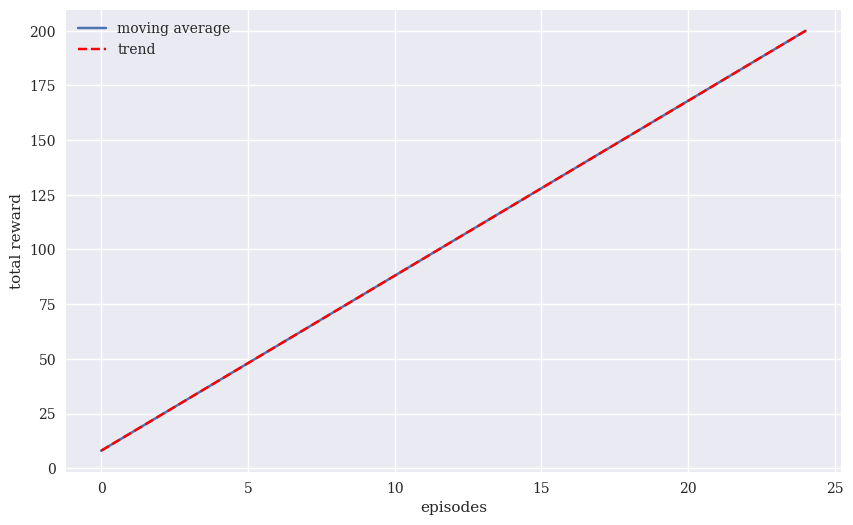

In [17]:
plt.figure(figsize=(10, 6))
x = range(len(agent.averages))
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='moving average')
plt.plot(x, y, 'r--', label='trend')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend()

In [18]:
trewards = agent.test(100)

In [19]:
sum(trewards) / len(trewards)

200.0

From the line above we see that the agent achieved a score of 200 (that is a "perfect score" in the CartPole exercise) consistently in it's test.

# Using the Same RL Agent in a Financial Setting

In [20]:
class observation_space:
    def __init__(self, n):
        self.shape = (n,)


class action_space:
    def __init__(self, n):
        self.n = n

    def seed(self, seed):
        pass

    def sample(self):
        return random.randint(0, self.n - 1)


class Finance:
    url = 'http://hilpisch.com/aiif_eikon_eod_data.csv'

    def __init__(self, symbol, features):
        self.symbol = symbol
        self.features = features
        self.observation_space = observation_space(4)
        self.osn = self.observation_space.shape[0]
        self.action_space = action_space(2)
        self.min_accuracy = 0.475
        self._get_data()
        self._prepare_data()

    def _get_data(self):
        self.raw = pd.read_csv(self.url, index_col=0,
                               parse_dates=True).dropna()

    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol])
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        self.data = (self.data - self.data.mean()) / self.data.std()
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)

    def _get_state(self):
        return self.data[self.features].iloc[
            self.bar - self.osn:self.bar].values

    def seed(self, seed=None):
        pass

    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.bar = self.osn
        state = self.data[self.features].iloc[
            self.bar - self.osn:self.bar]
        return state.values, {}

    def step(self, action):
        trunc = False
        correct = action == self.data['d'].iloc[self.bar]
        reward = 1 if correct else 0
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.osn)
        if self.bar >= len(self.data):
            done = True
            trunc = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and
              self.bar > self.osn + 10):
            done = True
            trunc = True
        else:
            done = False
        state = self._get_state()
        info = {}
        return state, reward, done, trunc, info

In [21]:
env = Finance('EUR=', 'EUR=')
env.reset()

a = env.action_space.sample()
a

0

In [22]:
env.step(a)

(array([1.8579, 1.7749, 1.8579, 1.947 ]), 0, False, False, {})

Let us now define our agent, and train it against the financial data.

In [23]:
set_seeds(100)
agent = DQLAgent(gamma=0.5, opt=keras.optimizers.legacy.RMSprop)
episodes = 1000

In [24]:
%time agent.learn(episodes)

CPU times: user 14min 5s, sys: 1min 1s, total: 15min 7s2511
Wall time: 13min 6s


In [25]:
agent.test(3)

[2511, 2511, 2511]

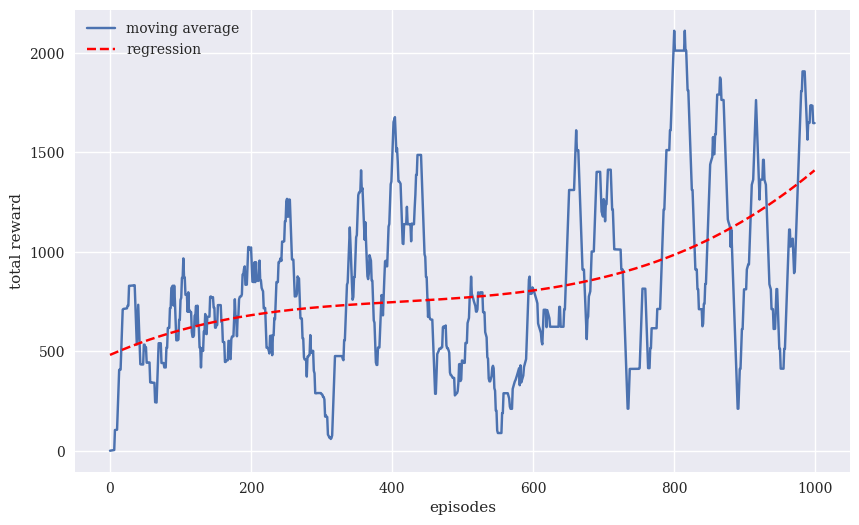

In [26]:
plt.figure(figsize=(10, 6))
x = range(len(agent.averages))
# Add a cubic least squares regression to elucidate the trend
y = np.polyval(np.polyfit(x, agent.averages, deg=3), x)
plt.plot(agent.averages, label='moving average')
plt.plot(x, y, 'r--', label='regression')
plt.xlabel('episodes')
plt.ylabel('total reward')
plt.legend()